# <span style="color:gold;">The Importance of Time Series Analysis in Quantitative Finance</span>

## <span style="color:darkorange;">Introduction</span>

In quantitative finance, time series analysis plays a pivotal role in understanding and forecasting financial data over time. Financial markets are inherently dynamic, with asset prices, interest rates, and volatility fluctuating continuously. Time series analysis enables analysts and traders to detect patterns, estimate future prices, and develop strategies based on the historical behavior of financial instruments.

By modeling the temporal dependence in financial data, time series analysis helps to capture trends, cycles, and volatility structures, which are crucial for pricing, risk management, and trading decisions. Common techniques used in time series analysis include:

- **ARIMA** (AutoRegressive Integrated Moving Average)
- **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity)
- **Exponential Smoothing**

This assignment explores ARIMA time series modeling techniques and provides a real-world example of predicting stock prices to inform trading decisions.

---

## <span style="color:yellow;">ARIMA (AutoRegressive Integrated Moving Average)</span>

ARIMA is one of the most popular techniques for time series forecasting, especially for data that shows temporal autocorrelation. ARIMA models can capture different patterns, including trends, seasonalities, and noise, making it a versatile tool in finance.

The ARIMA model consists of three key components:

- **AR (AutoRegressive)**: This part models the dependency between an observation and a certain number of lagged observations (previous values of the time series).

- **I (Integrated)**: The "integrated" part refers to differencing the data to make the time series stationary (i.e., removing trends and seasonality).

- **MA (Moving Average)**: This part models the dependency between an observation and the residual errors from previous time steps.

The notation for ARIMA is typically expressed as **ARIMA(p, d, q)**, where:

- **p**: The number of lag terms (autoregressive component).
- **d**: The number of differencing steps needed to make the series stationary.
- **q**: The number of lagged forecast errors (moving average component).

---

## <span style="color:yellow;">Finance Analogy</span>

Consider a stock price that shows a trend over time with small deviations due to random market factors. The AR component explains how past prices influence the current price, while the MA component captures how past errors (unexpected price movements) affect the forecast. The I component helps remove the trend, allowing us to forecast future stock prices by focusing on deviations from the historical pattern.

---

## <span style="color:yellow;">Example in Trading</span>

In stock trading, ARIMA can be used to predict short-term price movements. By training an ARIMA model on historical prices, traders can generate future price forecasts and develop strategies, such as entering buy/sell positions based on predicted price trends.

---

# <span style="color:green;">Quant Take Home Assessment for Sixpoint Capital Management</span>

Quant Take Home Assessment
### Key Requirements

1. **Input a Time Series**
   - The class should be able to accept a time series dataset as input.

2. **Stationarity Check**
   - Evaluate whether the input time series is stationary or not using appropriate statistical tests (e.g., **Augmented Dickey-Fuller test**).

3. **Differencing the Series**
   - Allow the user to apply differencing to the time series in order to make it stationary if needed.

4. **Evaluate Different ARIMA Models**
   - Provide the ability to evaluate different ARIMA models on the time series.

5. **Auto-Selection of Best ARIMA Model**
   - Automatically select and estimate the “best” ARIMA-time series model based on:
     1. **Lowest AIC** (Akaike Information Criterion).
     2. **No insignificant terms** according to a user-specified p-value threshold (e.g., `p < 0.05`).

6. **Simulate Forecasts of the Time Series Model**
   - The class should allow simulation of future values of the time series based on the selected ARIMA model.
     - **Parameters**:
       - Number of simulations (e.g., `10,000` simulations).
       - Number of forecast periods (e.g., forecast `10 periods` ahead).
     - **Noise Distribution**:
       - The noise term in the forecast must match the distribution of the residuals (i.e., they should **not** be normally distributed).
       - **Note**: Sampling with replacement is **not** allowed as a solution.

7. **Calculate Percent of Simulations Exceeding Threshold**
   - The class should calculate the percentage of simulations that exceed a user-specified threshold value in each forecast period.


---
# <span style="color:#FFD700;">Model Overview</span>

## <span style="color:#FF8C00;">1. Data Transformation & Stationarity</span>

Stock market data can exhibit trends with small deviations, making it ideal for applying an ARIMA model. The data audit involves checking for null values and selecting the appropriate features for forecasting. For Modeling purposes, we are going to use NVIDIA stock to analyze


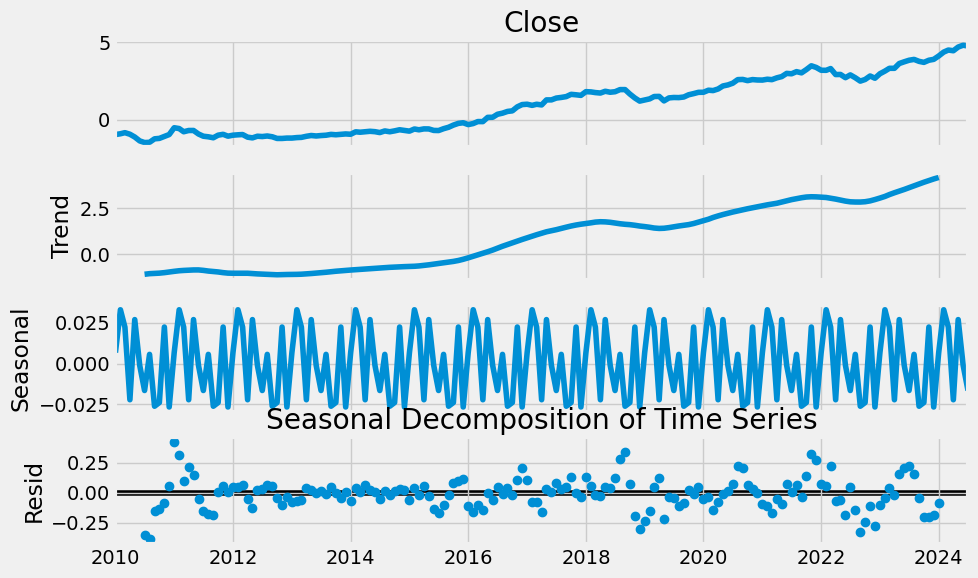

To apply the ARIMA model, it's crucial that the time series is stationary (i.e., constant mean and variance over time). Use the **Augmented Dickey-Fuller (ADF) Test** to determine if the series is stationary. If not, apply differencing until stationarity is achieved.

### <span style="color:#4682B4;">Stationarity Check:</span>
- A time series is stationary if its **mean**, **variance**, and **autocorrelation** remain constant over time.
- Non-stationary series may exhibit trends or seasonality and are harder to model.
- **Transforming** non-stationary data via differencing or detrending is common before applying statistical models like ARIMA.

### <span style="color:#4682B4;">Visual Cues to Assess Stationarity:</span>
- **Trend**: A consistent upward or downward movement in the trend component indicates non-stationarity.
- **Seasonality**: Repeating patterns may indicate seasonal components, though they do not always signify non-stationarity.
- **Residuals**: Should resemble random noise fluctuating around zero. Variability or clustering suggests non-stationarity.

### <span style="color:#4682B4;">Augmented Dickey-Fuller (ADF) Test:</span>
- A **statistical test** used to confirm stationarity.
- Determines if a **unit root** is present in the series, which is indicative of non-stationarity.

---

## <span style="color:#FF8C00;">3. Examine ACF and PACF Plots for Initial ARIMA Parameter Guesses</span>

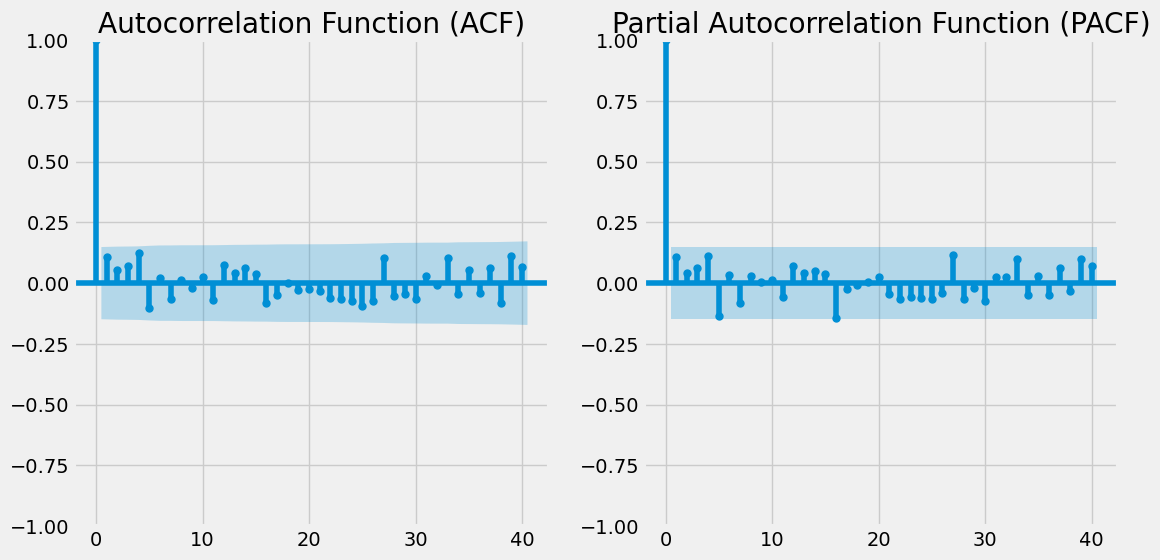

- **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** are used to estimate ARIMA parameters:
    - **p**: Number of autoregressive terms (from PACF).
    - **q**: Number of moving average terms (from ACF).
    - **d**: Differencing needed to make the series stationary.

### <span style="color:#4682B4;">ACF Plot:</span>
- Starts at 1.0 and exhibits several spikes.
- Significant spikes at lag 1 or 2 suggest an MA(q) process with **q = 1 or 2**.

### <span style="color:#4682B4;">PACF Plot:</span>
- Starts at 1.0 with a significant spike at lag 1.
- Suggests an AR(p) process with **p = 1**.

### <span style="color:#4682B4;">Suggested ARIMA(p, d, q) Values:</span>
- **p** = 1 (from PACF)
- **d** = 1 (if series became stationary after one differencing)
- **q** = 1 or 2 (from ACF)

Possible models: **ARIMA(1, 1, 1)** or **ARIMA(1, 1, 2)**.

---

## <span style="color:#FF8C00;">4. Model Diagnostics and Residuals Analysis</span>

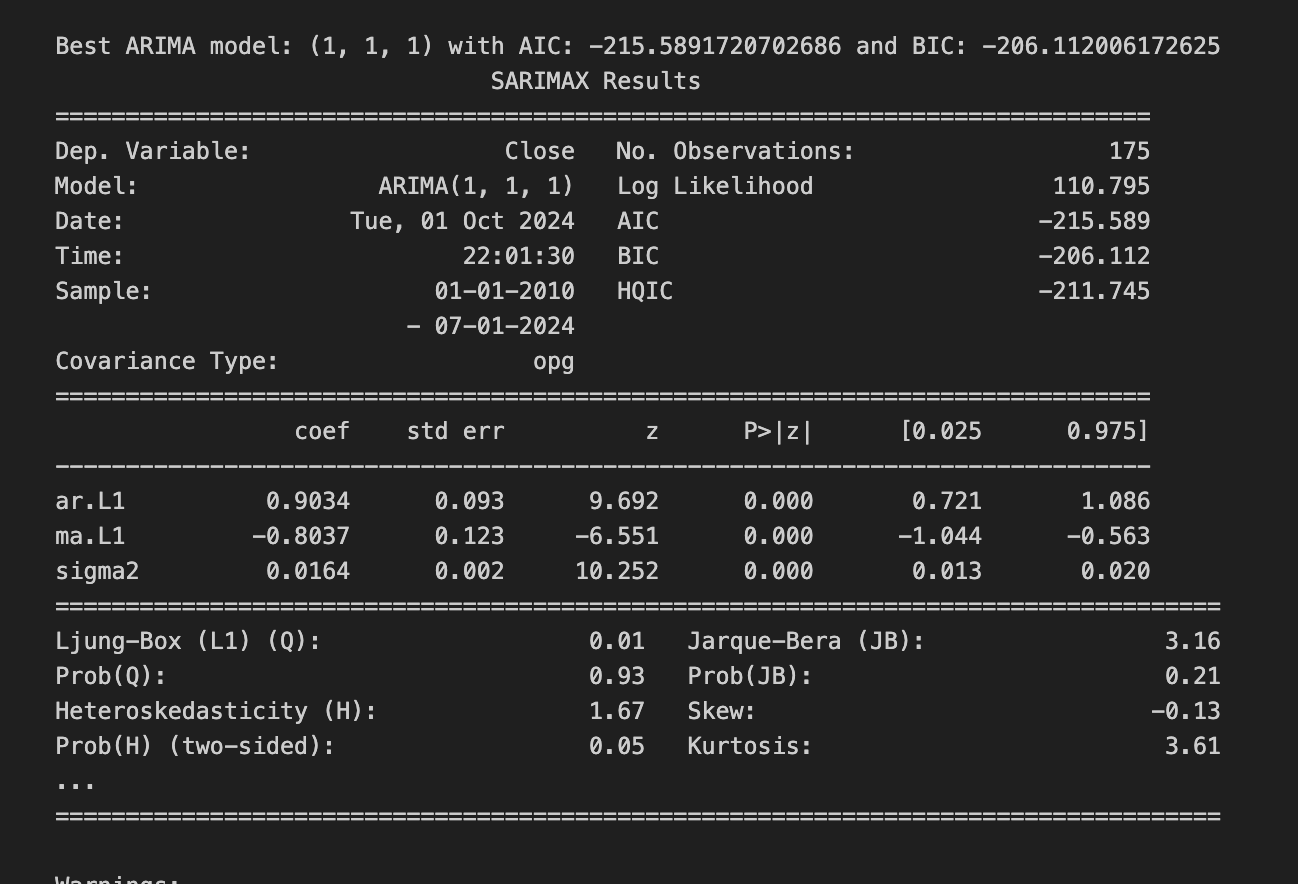

## Coefficients

1. **ar.L1 (Autoregressive coefficient)**:
   - **Value (coef)**: 0.9034

   **Interpretation**:
   - The coefficient of the AR term (`ar.L1`) is significant since `P>|z|` is 0, indicating a strong relationship between the current value and the first lag.
   - A coefficient close to 1 means a high degree of persistence in the time series, suggesting that past values strongly influence current values.

2. **ma.L1 (Moving Average coefficient)**:
   - **Value (coef)**: -0.8037

   **Interpretation**:
   - The MA term (`ma.L1`) is also significant with `P>|z|` of 0.
   - The negative coefficient suggests that past errors negatively affect future values. This means if there was an overestimate in one period, it is corrected in subsequent periods.

3. **sigma2 (Variance of residuals)**:
   - **Value (coef)**: 0.0164

   **Interpretation**:
   - The value represents the variance of the residuals, which quantifies the spread of the model’s errors. A lower value indicates that the model is capturing most of the variability in the data.


### <span style="color:#4682B4;">Diagnostic Plot Components:</span>
1. **Standardized Residuals**: 
   - Should fluctuate around zero with no clear pattern over time. Variability or spikes suggest model issues.
2. **Histogram + Density**: 
   - Residuals should follow a normal distribution. Deviations may indicate skewness or heavy tails.
3. **Normal Q-Q Plot**: 
   - Points should lie on the line if residuals are normally distributed. Deviations in the tails suggest non-normality.
4. **Correlogram**: 
   - No significant autocorrelations should remain in the residuals. If residuals are independent, the model captures temporal dependencies well.

### <span style="color:#4682B4;">Model Issues:</span>

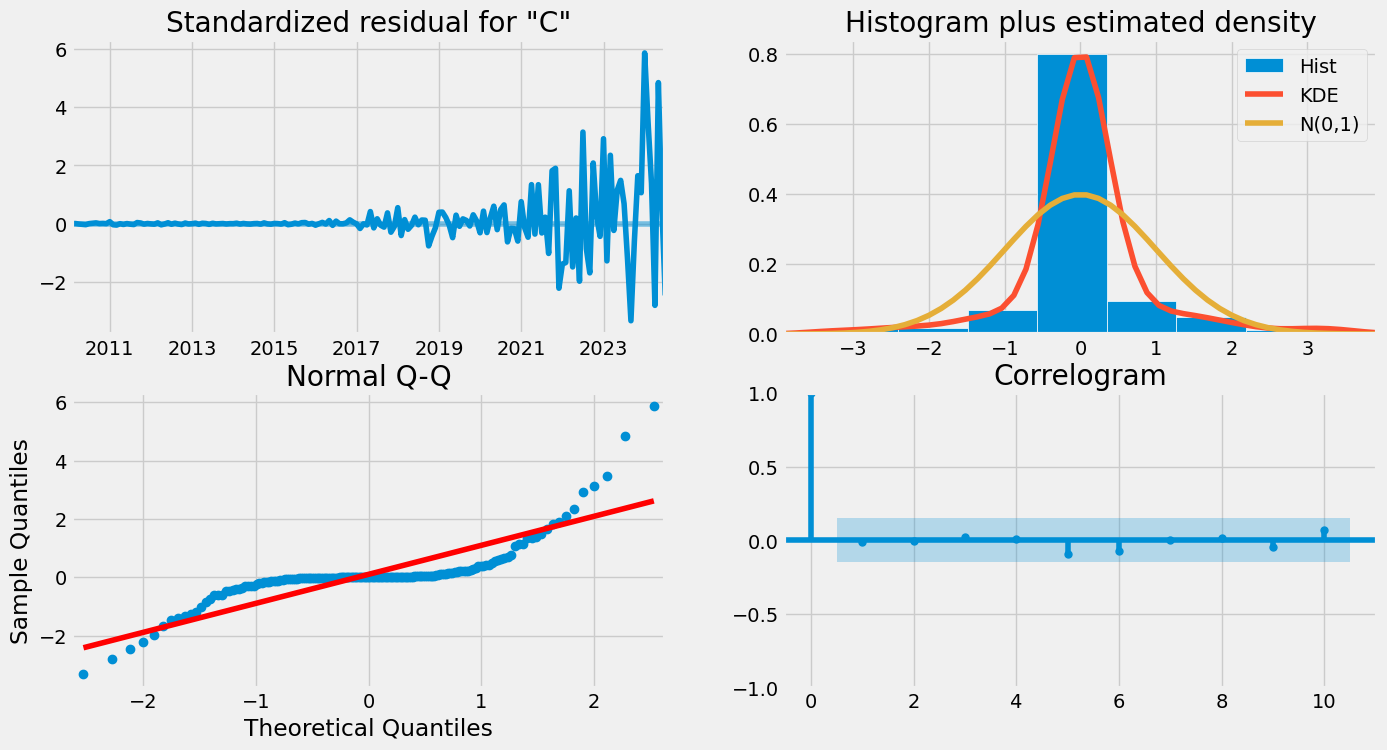

- **Heteroscedasticity**: Residuals show non-constant variance over time. The spikes around 2023 indicate periods where the model might not have performed well.
- **Non-normal Residuals**: Deviations in normality, especially at the tails. The deviation at the tails indicates that the residuals have heavier tails than expected, which suggests the presence of outliers or non-normality.
- **Histogram with KDE and Normal Density**: The goal is to check if the residuals follow a normal distribution. Ideally, the KDE line (in red) should closely match the normal distribution curve (in yellow). In this case, there is some deviation in the tails, indicating that the residuals are not perfectly normal, which could affect the accuracy of the model’s confidence intervals.



### <span style="color:#4682B4;">Possible Solutions:</span>
- Apply **log transformations** or **Box-Cox transformation** to stabilize variance.
- Consider **ARCH** or **GARCH** models if heteroscedasticity persists.

We used Log Transformation on time-series data before passing for modeling to handle residuals, here's the model results

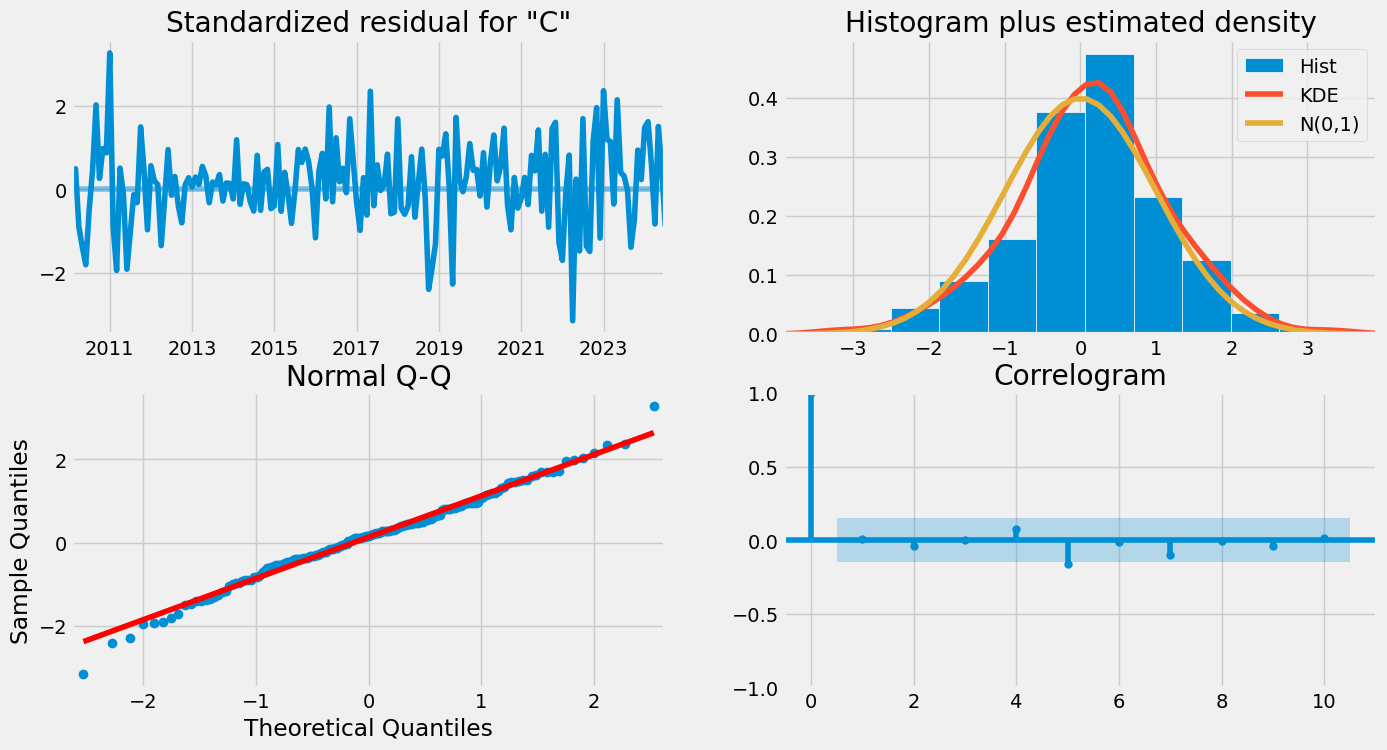
  
---

## <span style="color:#FF8C00;">5. Use Auto ARIMA to Optimize Parameters</span>

- **Auto ARIMA** helps automate the search for the best (p, d, q) values by minimizing the **AIC** or **BIC**.
- Example: **ARIMA(1, 1, 1)**, based on criteria like AIC = -215.589 and BIC = -206.112, providing a good model fit.

---

## <span style="color:#FF8C00;">7. Model Performance Evaluation Using Error Metrics</span>

- **MSE (Mean Squared Error)** = 387.29
    - Represents average squared prediction errors.
       - **Business context**: Since the MSE is 387.29, this means that, on average, the squared error in the model's predictions is about 387 units. However, due to squaring, it’s less interpretable in real-world stock price terms, which is why we look at RMSE.

- **RMSE (Root Mean Squared Error)** = 19.68
    - Gives error magnitude in stock price terms. An error of ~$19.68 is reasonable for the model.
       - **Business context**: With an RMSE of 19.68, the model is, on average, off by about $19.68 when predicting Tesla’s stock price. This could help businesses gauge the typical range of error to expect. For instance, if Tesla’s stock is trading around $250, an error of ~$19.68 represents a small percentage error.

- **MAE (Mean Absolute Error)** = 9.95
    - Represents average absolute prediction error in real-world stock prices.
    - **Business context**: The model's predictions are off by an average of $9.95 from the actual price. If a business were using this model to make financial decisions, it could expect to be within about $10 of the actual price most of the time.

- **MAPE (Mean Absolute Percentage Error)** = 12.71%
    - The model is off by 12.71% on average, a manageable error rate in stock predictions.
     - **Business context**: The model’s predictions are, on average, off by about 12.71%. This means that, for any given price prediction, the model is around 12.71% away from the true stock price. For a stock priced at $100, that would mean the model’s error would typically be around $12.71. This percentage error is useful for understanding the relative accuracy of the model, especially for businesses tracking error as a percentage of the stock price rather than an absolute value.


### **Summary in Business Terms**:
- **RMSE and MAE** provide a clear sense of how much the model’s predictions differ from the actual stock price, helping businesses understand typical prediction errors in dollar amounts.
- **MAPE** gives a relative measure of error, allowing businesses to understand the model's performance in terms of percentage accuracy.
- **MSE** is less directly interpretable for business but is useful for comparison with other models in terms of how the model minimizes large errors.

For decision-making, businesses would focus on metrics like **MAE** and **RMSE** to understand how much risk there is in the model's predictions and whether this error range is acceptable for investment or forecasting strategies.

---

## <span style="color:#FF8C00;">8. Simulated Forecasting</span>

### Model params:

   1. ticker='NVDA',      # Choose ticker: GOOGL, AMZN, MSFT, TSLA, NVDA
   2. start_date='2010-01-01', #Sampling Period
   3. end_date='2024-07-31',
   4. interval='1mo', # 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
   5. num_simulations=10000, # Number of simulations
   6. forecast_periods=40, # unit depends on interval 
   7. threshold_value=240, # stock price threhold in $
   8. p_value_threshold=0.05, #pvalue threhold
   9. risk_free_rate = 0 

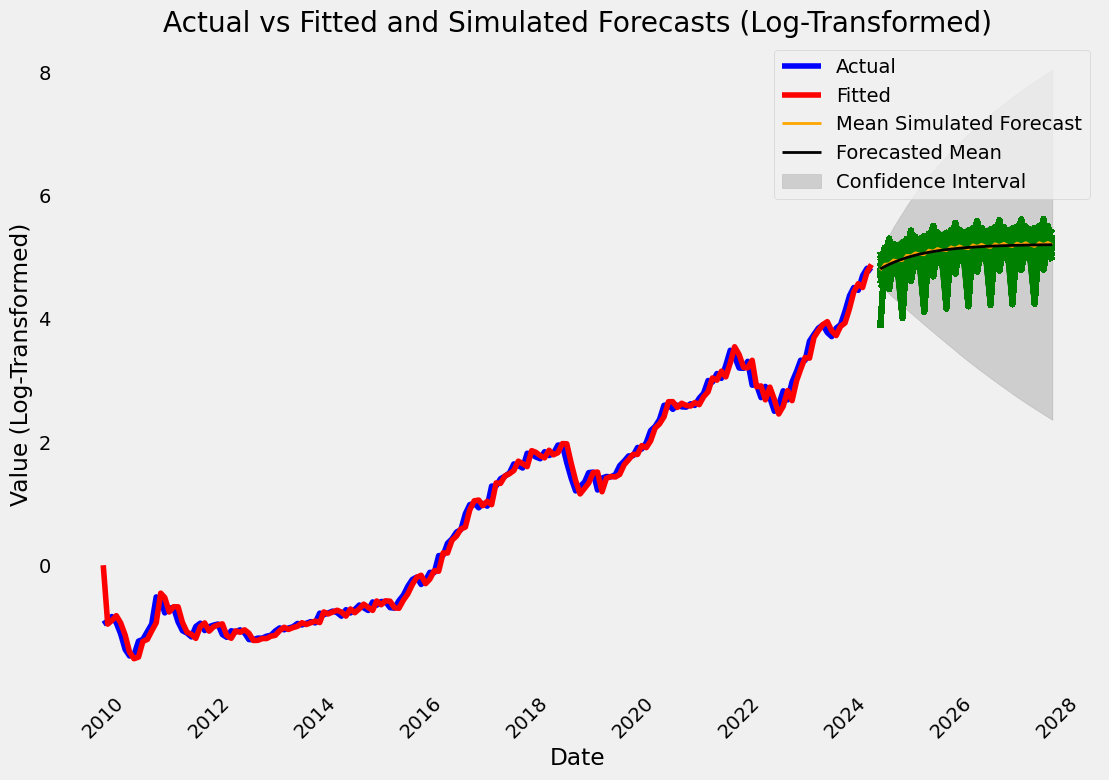

- Forecasting the log-transformed stock price shows an upward trend.
- The **black line** represents the forecast, while the **yellow line** shows the mean forecast.
- **Confidence intervals** widen into the future, reflecting increasing uncertainty.

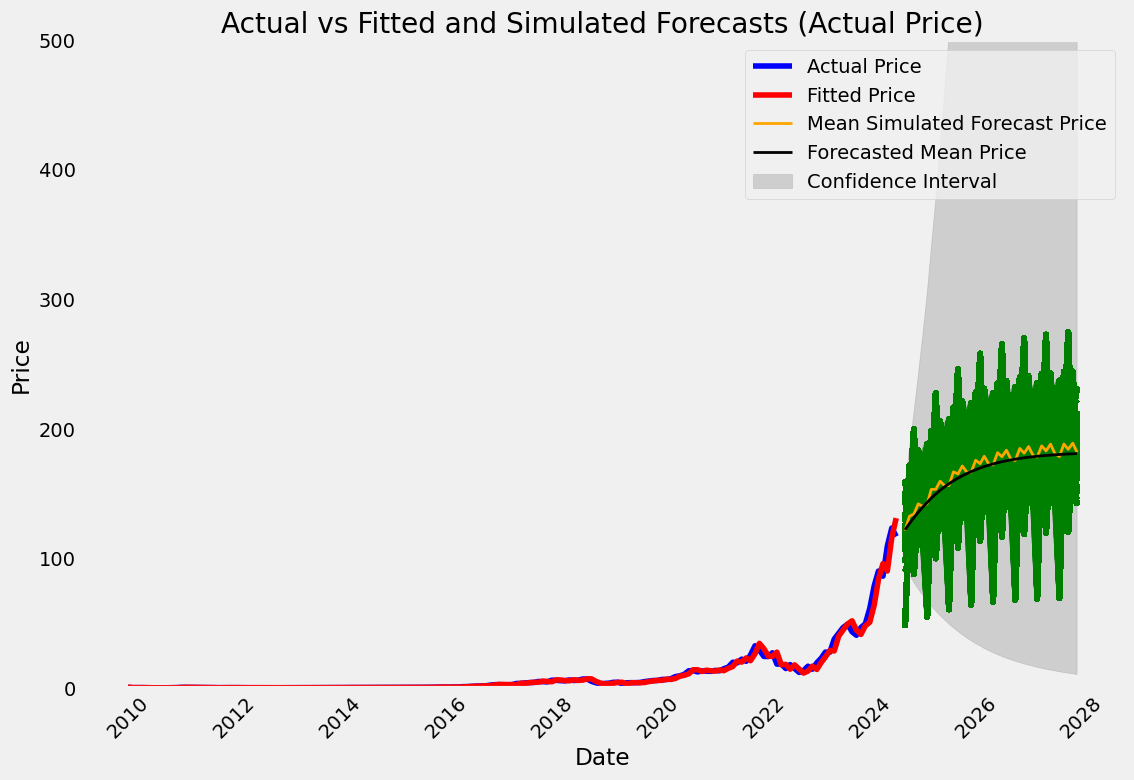

---

## <span style="color:#FF8C00;">9. Simulation Exceedance by Threshold</span>

- Shows potential stock price exceeding set thresholds.
- Useful for assessing risk and setting targets for decision-making.

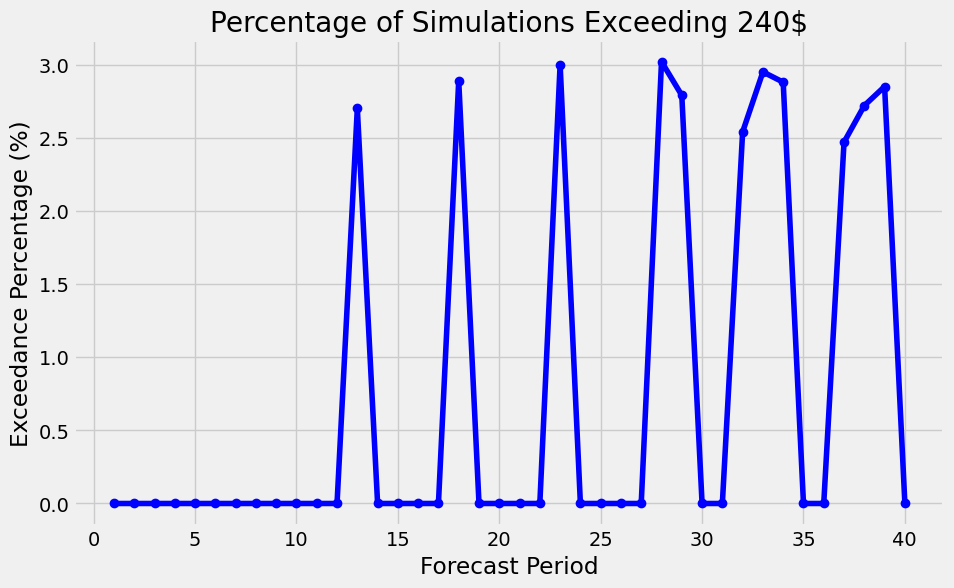


### <span style="color:#4682B4;">Summary:</span>
- The ARIMA model provides a reasonable fit but may require adjustments for heteroscedasticity.
- Forecasts show an upward trend with increasing variability, suggesting stock prices may rise, but the future is uncertain.

---


# <span style="color:green;">Class Overview</span>

### <span style="color:yellow;">Methods to be Included</span>

#### <span style="color:darkorange;">1. Initialization</span>
- Takes as input a time series.

#### <span style="color:darkorange;">2. Stationarity Evaluation</span>
- Evaluates whether the series is stationary or not.

#### <span style="color:darkorange;">3. Differencing</span>
- Allows the user to difference the series.

#### <span style="color:darkorange;">4. ARIMA Model Evaluation</span>
- Evaluates different ARIMA time series models.

#### <span style="color:darkorange;">5. Best Model Selection</span>
- Automatically selects and estimates the “best” ARIMA time series model using the following criteria:
  - The model with the lowest AIC.
  - No insignificant terms according to a user-specified p-value.

#### <span style="color:darkorange;">6. Forecast Simulation</span>
- Simulates forecasts of the time series model with the following parameters:
  - The number of forecasts (e.g., user can specify 10,000 simulations).
  - The number of forecast periods (e.g., user specifies forecasting 10 periods ahead).
  - Ensures the distribution of the noise term in the forecast matches the distribution of the residuals (i.e., they should not be normally distributed).
  - Avoids sampling with replacement as a solution.

#### <span style="color:darkorange;">7. Exceedance Calculation</span>
- Calculates what percentage of simulations exceed a user-specified value in each forecast period.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown


class ARIMAStockForecasting:
    # Initializing control variables, providing more flexible forecasting 
    def __init__(self, ticker, start_date, end_date, interval, num_simulations, forecast_periods, threshold_value, p_value_threshold, risk_free_rate):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.num_simulations = num_simulations
        self.forecast_periods = forecast_periods
        self.threshold_value = threshold_value
        self.p_value_threshold = p_value_threshold
        self.risk_free_rate = risk_free_rate
        self.data = None
        self.data_diff = None
        self.best_model = None
        self.best_order = None
        self.predictions_df = None  # To store forecasted prices

    def download_stock_data(self):
        # Fetching Tesla time-series stock data to forecast
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, interval=self.interval)['Close']
        # print(self.data)

    def apply_log_transform(self):
        self.data = np.log(self.data)
        # self.data_diff = self.data.diff().dropna()

    def check_stationarity(self):
        result = sm.tsa.stattools.adfuller(self.data.dropna())
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[4])
        return result[1] < 0.05  # Returns True if the series is stationary

    def check_seasonality(self):
        seasonal_decompose = sm.tsa.seasonal_decompose(self.data, model='additive', period=12)  # Adjust period as needed
        seasonal_decompose.plot()
        plt.title('Seasonal Decomposition of Time Series')
        plt.show()
        return seasonal_decompose.seasonal.mean()  # Returns the average seasonal component

    def difference_series(self):
        self.data_diff = self.data.diff().dropna()
        print("Series differenced to make it stationary.")

    def plot_acf_pacf(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(self.data_diff, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function (ACF)')
        plt.subplot(122)
        plot_pacf(self.data_diff, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function (PACF)')
        plt.show()

    def fit_arima_model(self):

        p_range = range(0, 6) 
        d_range = range(0, 2)
        q_range = range(0, 6)

        best_aic = np.inf
        best_bic = np.inf

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    try:
                        model = ARIMA(self.data, order=(p, d, q)).fit()
                        current_aic = model.aic
                        current_bic = model.bic
                        significant_terms = model.pvalues[model.pvalues < self.p_value_threshold].count() == len(model.pvalues)

                        if current_aic < best_aic and significant_terms:
                            best_aic = current_aic
                            best_bic = current_bic
                            self.best_order = (p, d, q)
                            self.best_model = model
                        print(f"ARIMA({p},{d},{q}) - AIC: {current_aic}, BIC: {current_bic}, Significant Terms: {significant_terms}")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q}) failed: {e}")
                        continue

        if self.best_model is not None:
            print(f"\nBest ARIMA model: {self.best_order} with AIC: {best_aic} and BIC: {best_bic}")
        else:
            print("No suitable ARIMA model found.")

    def plot_diagnostics(self):
        if self.best_model is not None:
            print(self.best_model.summary())
            self.best_model.plot_diagnostics(figsize=(15, 8))
            plt.show()

    def calculate_error_metrics(self):
        if self.best_model is not None:
            actual = self.data[self.best_model.fittedvalues.index]
            fitted = self.best_model.fittedvalues
            
            mse = mean_squared_error(actual, fitted)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(actual, fitted)
            mape = np.mean(np.abs((actual - fitted) / actual)) * 100
            
            print(f"MSE: {mse}")
            print(f"RMSE: {rmse}")
            print(f"MAE: {mae}")
            print(f"MAPE: {mape}%")


    def plot_residuals(self):
        if self.best_model is not None:
            residuals = pd.DataFrame(self.best_model.resid)
            # residuals.plot(title="Residuals")
            # plt.show()

    def apply_garch(self):

        display(Markdown(
        """ 
        GARCH Interpretation:

	    Conditional Volatility: The GARCH model provides the conditional volatility,
        which measures the changing level of risk or variability in the time series. 
        We can analyze how volatility evolves over time based on this model.
        
        """     ))

        if self.best_model is not None:
            # Fit GARCH model to ARIMA residuals
            residuals = self.best_model.resid
            garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
            garch_fit = garch_model.fit(disp="off")
            print(garch_fit.summary())
            return garch_fit

    def forecast(self):
        # Generate forecast for the specified periods
        if self.best_model is not None:
            forecast = self.best_model.get_forecast(steps=self.forecast_periods)
            forecast_mean = forecast.predicted_mean
            forecast_index = pd.date_range(start=self.data.index[-1], periods=self.forecast_periods, freq='M')

            # Create a DataFrame with the forecasted values
            self.predictions_df = pd.DataFrame({'Date': forecast_index, 'predicted_price': np.exp(forecast_mean)})
            self.predictions_df.set_index('Date', inplace=True)

            # # Plotting the actual, fitted, and forecasted values
            # plt.figure(figsize=(10, 6))
            # plt.plot(self.data.index, np.exp(self.data), label='Actual Price', color='blue')
            # plt.plot(self.best_model.fittedvalues.index, np.exp(self.best_model.fittedvalues), color='red', label='Fitted Price')
            # plt.plot(self.predictions_df.index, self.predictions_df['predicted_price'], color='green', label='Forecasted Price')
            # plt.fill_between(self.predictions_df.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
            # plt.legend()
            # plt.title('Actual vs Fitted and Forecasted Values')
            # plt.show()
            return self.predictions_df
        


    def simulate_predictions(self):
        if self.best_model is None:
            print("No fitted model available.")
            return

        # Generate Forecasts
        forecast = self.best_model.get_forecast(steps=self.forecast_periods)
        forecast_mean = forecast.predicted_mean
        residuals = self.best_model.resid

        # Block Bootstrap Parameters
        block_size = 5  # Number of consecutive residuals to sample as a block . formula (numner of datapoints)1/3 
        num_blocks = len(residuals) // block_size

        # Moving Block Bootstrap Function
        def moving_block_bootstrap(residuals, block_size, periods):
            """Generates bootstrapped residuals using moving block bootstrap."""
            indices = np.random.choice(range(num_blocks), size=periods, replace=True)
            bootstrap_residuals = np.concatenate([residuals[i * block_size:(i + 1) * block_size] for i in indices])
            return bootstrap_residuals[:periods]

        # Simulate Predictions
        simulations = []
        for _ in range(self.num_simulations):
            simulated_residuals = moving_block_bootstrap(residuals, block_size, self.forecast_periods)
            simulated_values = forecast_mean + simulated_residuals  # Adding noise for simulated forecasts
            simulations.append(simulated_values)

        simulations = np.array(simulations)
        print("loged simulations....")
        print(simulations)
        
        # Calculate Exceedance Percentages (Exponentiated Values)
        simulations_exp = np.exp(simulations)
        print("Actual price simulations....")
        print(simulations_exp)
        exceed_percentages = (simulations_exp > self.threshold_value).mean(axis=0) * 100

        # Create DataFrames for Simulations and Exceedance Percentages
        simulation_df = pd.DataFrame(simulations_exp, columns=[f"Period {i + 1}" for i in range(self.forecast_periods)])
        exceed_df = pd.DataFrame({"Period": range(1, self.forecast_periods + 1), "Exceed %": exceed_percentages})
        # print(exceed_df)
        # Set Forecast Index
        forecast_index = pd.date_range(start=self.data.index[-1] + pd.DateOffset(months=1), periods=self.forecast_periods, freq='M')

        # Plotting Log-Transformed Series
        plt.figure(figsize=(12, 8))
        plt.plot(self.data, label='Actual', color='blue')
        plt.plot(self.best_model.fittedvalues, color='red', label='Fitted')
        for i in range(simulations.shape[0]):
            plt.plot(forecast_index, simulations[i], color='green', alpha=0.1)
        mean_simulation = simulations.mean(axis=0)
        plt.plot(forecast_index, mean_simulation, color='orange', label='Mean Simulated Forecast', linewidth=2)
        conf_int = forecast.conf_int()
        plt.plot(forecast_index, forecast.predicted_mean, color='black', label='Forecasted Mean', linewidth=2)
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
        plt.legend()
        plt.title('Actual vs Fitted and Simulated Forecasts (Log-Transformed)')
        plt.xlabel('Date')
        plt.ylabel('Value (Log-Transformed)')
        plt.xticks(rotation=45)
        plt.grid()
        plt.show() 

        # Plotting Actual Price Forecasts (Exponentiated Values)
        plt.figure(figsize=(12, 8))
        plt.plot(np.exp(self.data), label='Actual Price', color='blue')
        plt.plot(np.exp(self.best_model.fittedvalues), color='red', label='Fitted Price')
        for i in range(simulation_df.shape[0]):
            plt.plot(forecast_index, simulation_df.iloc[i], color='green', alpha=0.1)
        mean_simulation_exp = simulation_df.mean(axis=0)
        plt.plot(forecast_index, mean_simulation_exp, color='orange', label='Mean Simulated Forecast Price', linewidth=2)
        conf_int_exp = np.exp(conf_int)
        plt.plot(forecast_index, np.exp(forecast.predicted_mean), color='black', label='Forecasted Mean Price', linewidth=2)
        plt.fill_between(forecast_index, conf_int_exp.iloc[:, 0], conf_int_exp.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
        plt.ylim(0, 1000)  # Compress Y-axis range from 0 to 500
        plt.legend()
        plt.title('Actual vs Fitted and Simulated Forecasts (Actual Price)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

        # Plotting Exceedance Percentages
        plt.figure(figsize=(10, 6))
        plt.plot(exceed_df['Period'], exceed_df['Exceed %'], marker='o', linestyle='-', color='blue')
        plt.title(f'Percentage of Simulations Exceeding {self.threshold_value}$')
        plt.xlabel('Forecast Period')
        plt.ylabel('Exceedance Percentage (%)')
        plt.grid(True)
        plt.show()

    def run(self):
        self.download_stock_data()
        self.apply_log_transform()
        if not self.check_stationarity():
            print("The series is not stationary. Checking for seasonality...")
            self.check_seasonality()
            self.difference_series()  # Allow user to decide whether to difference after checking seasonality
        self.plot_acf_pacf()
        self.fit_arima_model()
        self.plot_diagnostics()
        self.calculate_error_metrics()
        self.plot_residuals()
        # self.apply_garch()
        self.forecast()
        self.simulate_predictions()
        # trading_data = self.generate_trading_strategy()
        # if trading_data is not None:
        #     print(trading_data.tail())

[*********************100%***********************]  1 of 1 completed


ADF Statistic: 1.387666303049852
p-value: 0.9970573852819008
Critical Values: {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
The series is not stationary. Checking for seasonality...


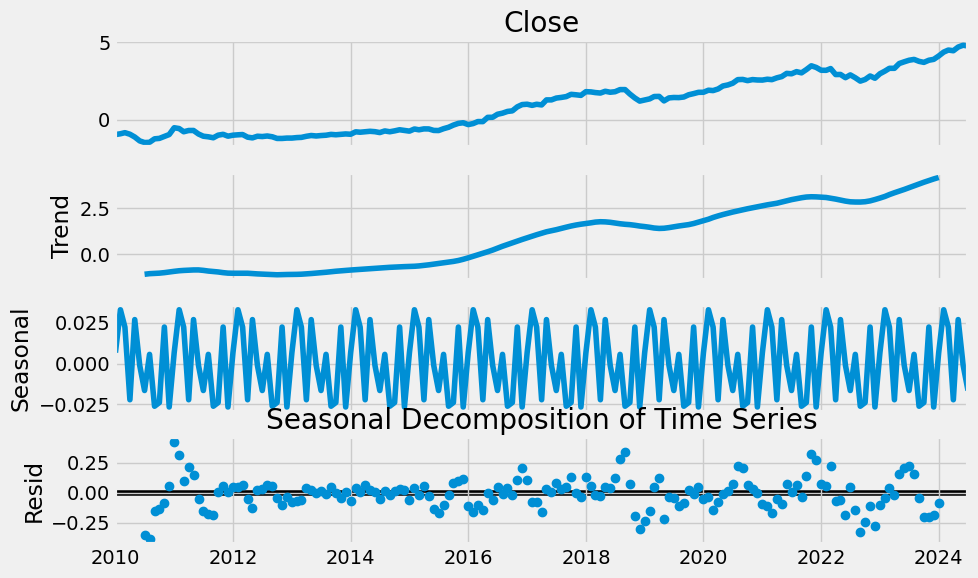

Series differenced to make it stationary.


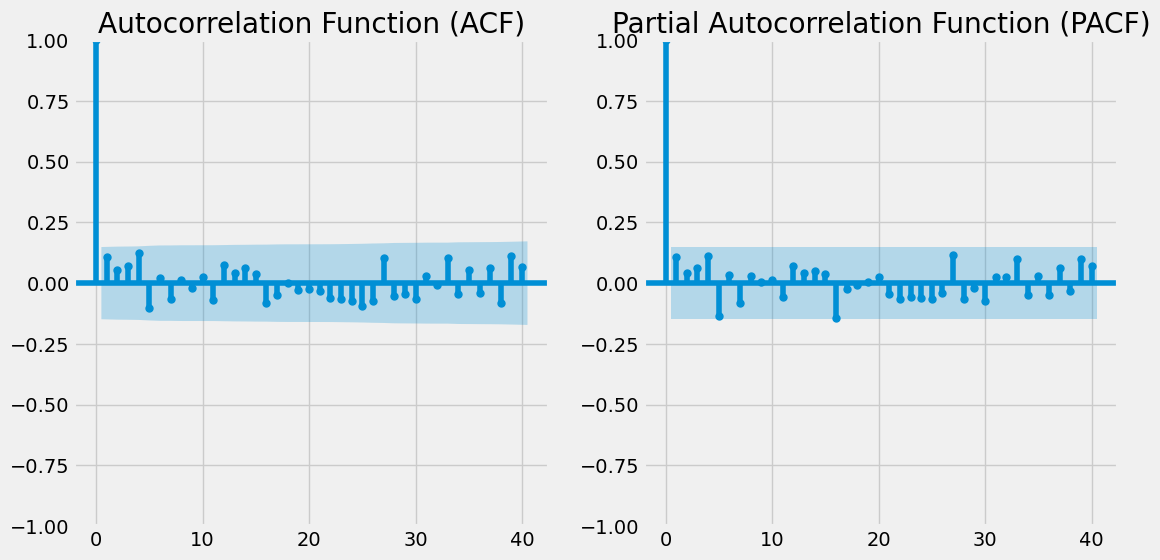

ARIMA(0,0,0) - AIC: 705.6560754420791, BIC: 711.9856473899262, Significant Terms: True
ARIMA(0,0,1) - AIC: 487.8874744290482, BIC: 497.38183235081874, Significant Terms: True
ARIMA(0,0,2) - AIC: 306.8463651656417, BIC: 319.5055090613358, Significant Terms: True
ARIMA(0,0,3) - AIC: 196.74161431093432, BIC: 212.5655441805519, Significant Terms: True
ARIMA(0,0,4) - AIC: 107.08595808338416, BIC: 126.07467392692524, Significant Terms: True
ARIMA(0,0,5) - AIC: 51.12005755430491, BIC: 73.27355937176951, Significant Terms: True
ARIMA(0,1,0) - AIC: -210.62138073221598, BIC: -207.46232543300147, Significant Terms: True
ARIMA(0,1,1) - AIC: -212.6181955415022, BIC: -206.30008494307313, Significant Terms: False
ARIMA(0,1,2) - AIC: -211.58281852916824, BIC: -202.10565263152466, Significant Terms: False
ARIMA(0,1,3) - AIC: -210.76324772829827, BIC: -198.12702653144015, Significant Terms: False
ARIMA(0,1,4) - AIC: -214.86834730220534, BIC: -199.0730708061327, Significant Terms: False
ARIMA(0,1,5) - AI

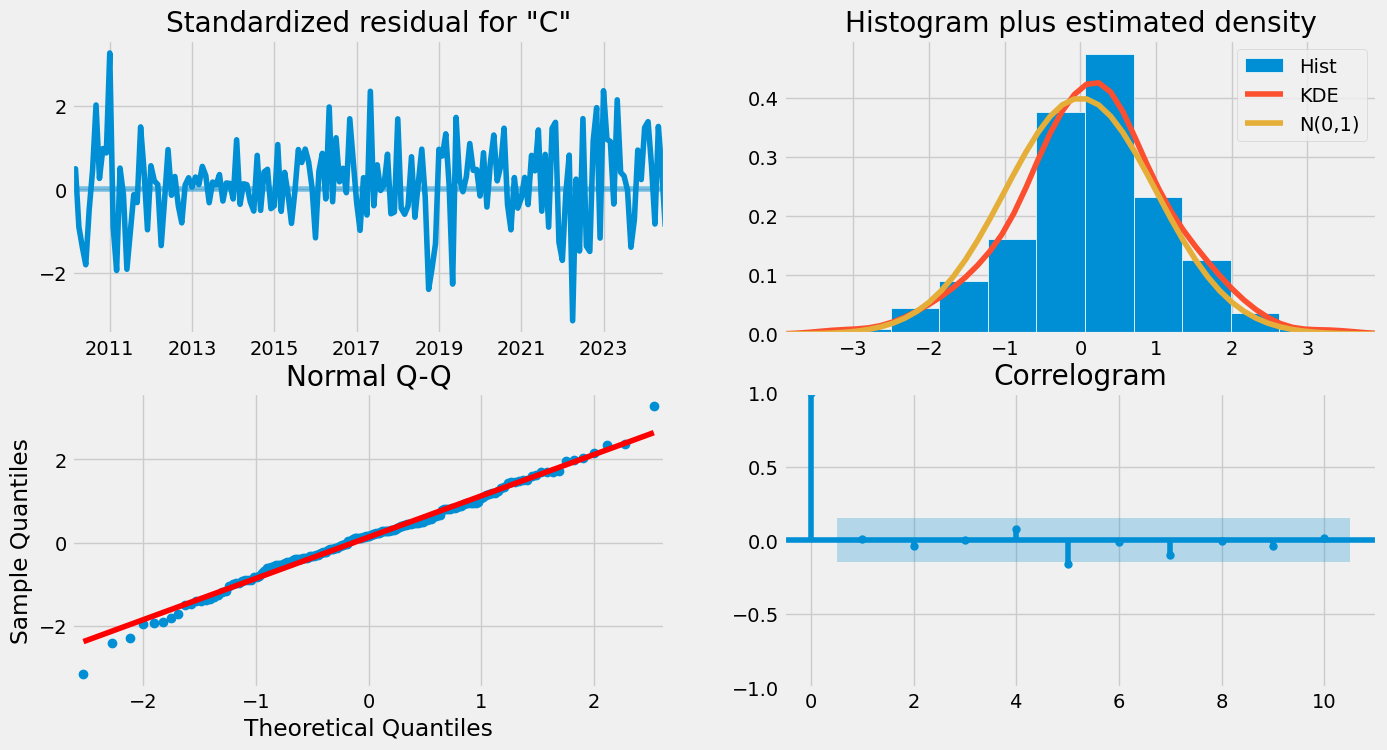

MSE: 0.02150125602830254
RMSE: 0.14663306594456293
MAE: 0.10399154403179824
MAPE: 10.13276873432004%
loged simulations....
[[4.76938445 4.86352496 4.8971787  ... 5.12923059 5.2497885  5.18398532]
 [4.86986898 4.83371769 5.09559288 ... 5.25001993 5.25923237 5.13928205]
 [4.97571587 4.85177125 4.58818864 ... 5.2110038  5.15903312 5.13183074]
 ...
 [4.90949722 4.77953839 4.93225355 ... 5.37910049 5.1307094  5.30571512]
 [5.02222262 4.66994408 4.68842172 ... 5.16911127 5.23424972 5.1517563 ]
 [5.07998584 4.89635358 4.91974676 ... 5.14256517 5.27927985 5.36522423]]
Actual price simulations....
[[117.84667881 129.47980982 133.9114423  ... 168.8871248  190.52596881
  178.3923475 ]
 [130.30384313 125.67732224 163.30063321 ... 190.57006564 192.33379379
  170.59324676]
 [144.85248302 127.9668502   98.31618261 ... 183.27794004 173.9961413
  169.32682862]
 ...
 [135.57123514 119.0493832  138.69170982 ... 216.82714892 169.13706186
  201.48503741]
 [151.74820797 106.69177648 108.68151401 ... 175.758

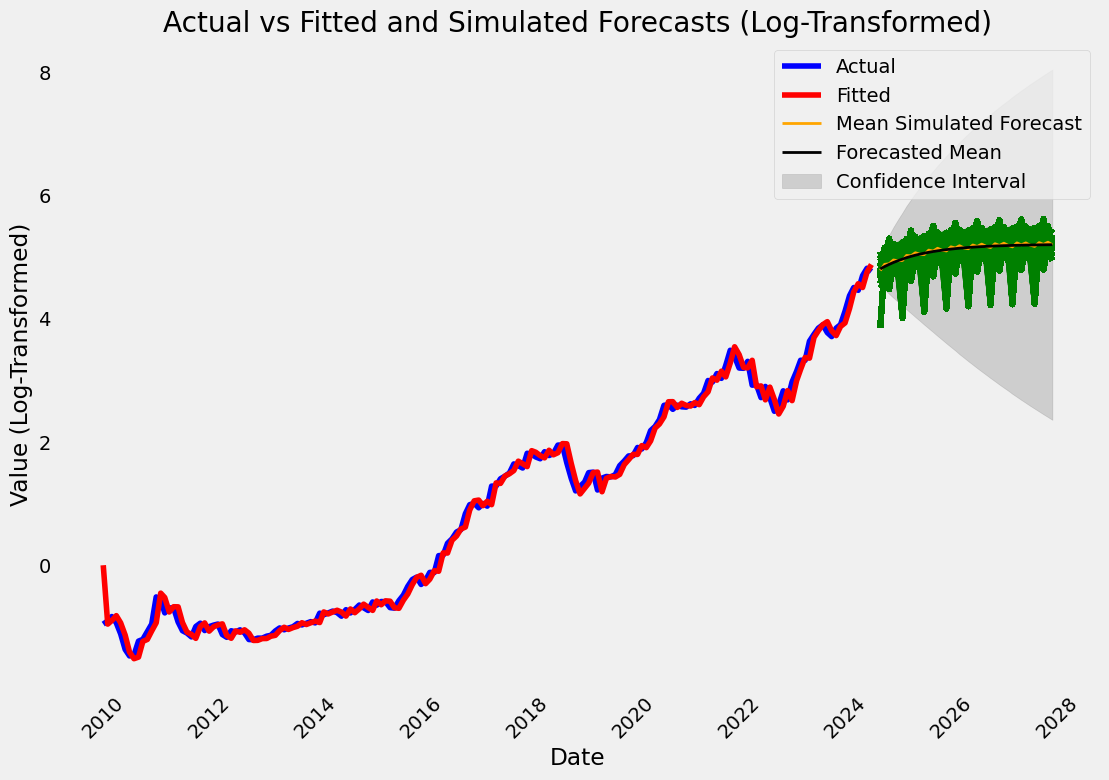

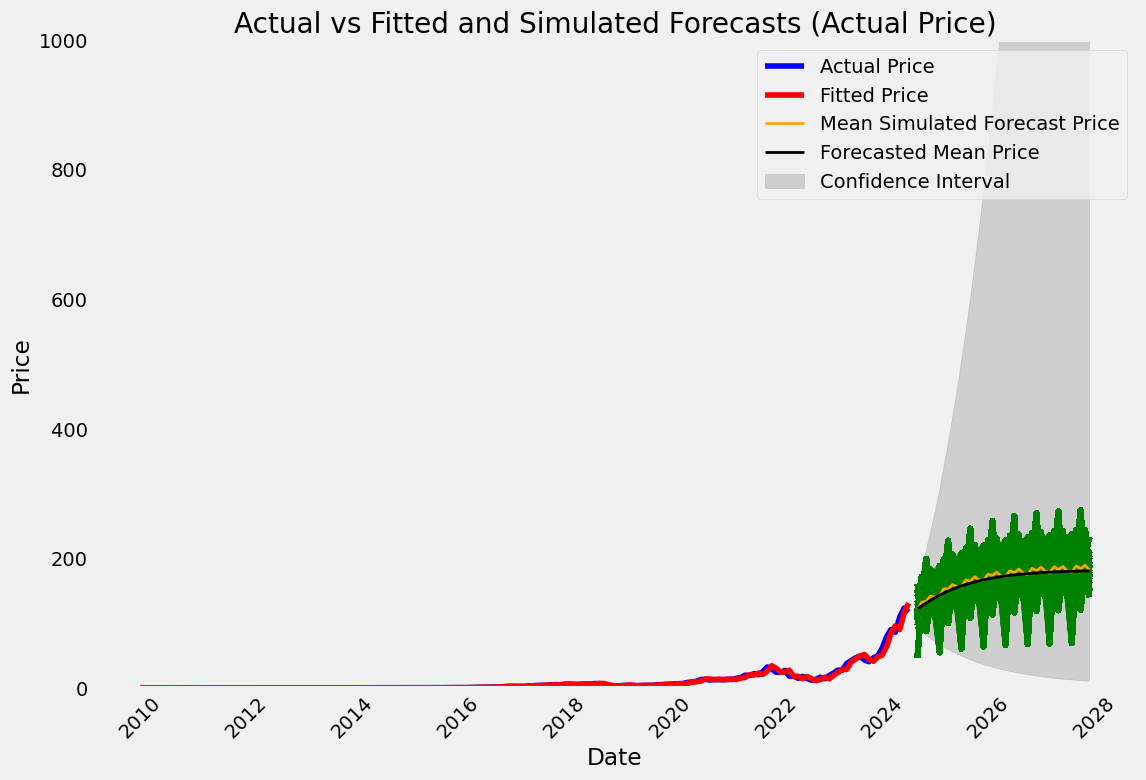

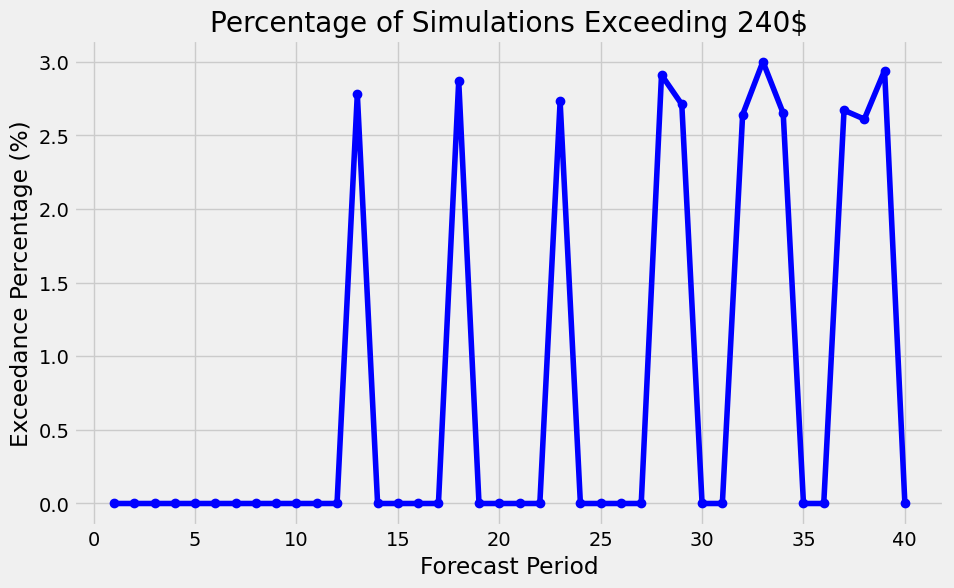

In [125]:

model = ARIMAStockForecasting(
    ticker='NVDA',      # Choose ticker: GOOGL, AMZN, MSFT, TSLA, NVDA
    start_date='2010-01-01', #Sampling Period
    end_date='2024-07-31',
    interval='1mo', # 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
    num_simulations=10000, # Number of simulations
    forecast_periods=40, # unit depends on interval 
    threshold_value=240, # stock price threhold in $
    p_value_threshold=0.05, #pvalue threhold
    risk_free_rate = 0  #just in case if want to calculate sharp ratio 
        # text{Sharpe Ratio} = \frac{\text{Average Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Returns}}

    
)

model.run()

### How can we define the best p-value threshold by looking at distribution of stock? 

Defining the best p-value threshold for ARIMA model selection by analyzing the distribution of stock data requires balancing statistical significance and the underlying characteristics of the stock’s time series. Here’s how you can approach it:

Steps to Define the Best p-Value Threshold:

	1.	Analyze the Stock Price Distribution:
	•	Look for Normality: If the stock price distribution is approximately normal, smaller p-value thresholds (e.g., 0.01, 0.05) may work well because you’re focusing on strict significance. However, stock prices often exhibit non-normality, volatility, and trends, meaning that you might need a more lenient threshold (e.g., 0.10 or higher) to capture important model features.
	•	Skewness and Kurtosis: If the distribution is highly skewed or has fat tails, consider higher p-value thresholds (0.10 or 0.15) since some features might still be important but show higher p-values due to market anomalies.
	2.	Plot the Distribution:
	•	Plot a histogram of the stock price returns (not prices) or use a kernel density estimate (KDE) to visualize the underlying distribution.
	•	You can also plot QQ plots to compare the stock return distribution against a normal distribution.
    3.	Consider Volatility and Outliers:
	•	If the stock has high volatility (common in stocks like TSLA), lower p-value thresholds might exclude too many relevant terms, leading to underfitting. In such cases, a slightly higher p-value (e.g., 0.1) might be more appropriate.
	•	For stable stocks, stricter thresholds (0.05 or lower) might work better because significant patterns will emerge more clearly.
	4.	Compare Model Performance with Different p-Values:
	•	Run your ARIMA model with different p-value thresholds (e.g., 0.01, 0.05, 0.10, 0.15) and compare the models’ error metrics (e.g., AIC, RMSE, MAPE).
	•	Look for a threshold that balances a good fit (lower AIC/BIC) without overfitting (keeping the number of terms reasonable).
	5.	Cross-Validation:
	•	Use time-series cross-validation to evaluate model performance across different thresholds. The best p-value threshold would be the one that gives the lowest validation error.
	6.	Evaluate Statistical Significance:
	•	Lower p-values (e.g., 0.01) indicate that the terms are strongly significant and help reduce the chance of including irrelevant terms. However, this could cause the model to miss important, but less significant, terms.
	•	Higher p-values (e.g., 0.10–0.15) allow more flexibility but could increase the risk of overfitting by including noise.